<a href="https://colab.research.google.com/github/jylin04/mi-ntk/blob/main/modular_arithmetic_1L_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup (run this and *'d cells at start)

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import math

import numpy as np
import torch as t

from torch import nn, Tensor
from torch.nn import functional as F

from tqdm.notebook import tqdm

from typing import Tuple, Optional

In [3]:
import matplotlib.pyplot as plt

In [4]:
%pip install -q git+https://github.com/jylin04/mi-ntk.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
import ntk, ma

from ma import Quadratic, Scale, ModularArithmeticMLP
from ma import build_mod_arith_data, build_mod_arith_data_symbreak, train, test
from ntk import full_jacobian, class_jacobian, jacobian_by_layer, empirical_ntk, empirical_ntk_by_layer, empirical_ntk_by_layer_cpu, LinearisedPredictor, eig_decompose
from ntk import axis_laplacians_pxp, two_stage_axis_diagonalization

In [6]:
# cfg
epochs: int = 5000
batch_size: int = 1024
lr: float = 1e-3
n_features: int = 80
n_hidden: int = 20
sparsity: float = 0.9
importance: float = 0.9

device = t.device("cuda" if t.cuda.is_available() else "cpu")
seed = 40

t.manual_seed(seed)

# 1. Reproduce grokking results

## Train the toy model*

In [7]:
class HyperParams:
  p: int = 29
  d_model: int = 64
  d_mlp = 256
  n_heads = 4
  alpha: float = 0.5
  lr: float = 3e-4
  wd: float = 1.0
  batch_size = 64
  epochs: int = 4000 #6000
  #eval_every: int = 100
  log_every: int = 20
  seed: int = 2

params = HyperParams()
t.manual_seed(params.seed)

device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [ ]:
# Neel Nanda's hyperaparameters (5x larger model)
'''
class HyperParams:
  p: int = 113
  d_model: int = 128
  d_mlp = 512
  n_heads = 4
  alpha: float = 0.3
  lr: float = 0.001
  wd: float = 1.0
  batch_size = 12769
  epochs: int = 20000
  #eval_every: int = 100
  log_every: int = 20
  seed: int = 0

params = HyperParams()
t.manual_seed(params.seed)

device = t.device("cuda" if t.cuda.is_available() else "cpu")'''

'\nclass HyperParams:\n  p: int = 113\n  d_model: int = 128\n  d_mlp = 512\n  n_heads = 4\n  alpha: float = 0.3\n  lr: float = 0.001\n  wd: float = 1.0\n  batch_size = 12769\n  epochs: int = 20000\n  #eval_every: int = 100\n  log_every: int = 20\n  seed: int = 0\n\nparams = HyperParams()\nt.manual_seed(params.seed)\n\ndevice = t.device("cuda" if t.cuda.is_available() else "cpu")'

In [8]:
# -------- Dataset --------
import random

def gen_train_test_with_labels(frac_train:float, p:int, seed: int=0) -> Tuple[np.array, np.array, np.array, np.array]:
  """
  Returns:
  train_pairs: (int(frac_train*len(pairs)), 3))
  train_labels: (int(frac_train*len(pairs)),)
  test_pairs:  (1-int(frac_train*len(pairs)), 3))
  test_labels: (1-int(frac_train*len(pairs)),)
  """
  pairs = [(i,j,p) for i in range(p) for j in range(p)]
  random.seed(seed)
  random.shuffle(pairs)
  train_pairs = np.array(pairs[:int(frac_train*len(pairs))])  # prev: np.array(pairs[:int(frac_train*len(pairs))], dtype='object') w/third entry being '='
  train_labels = (train_pairs[:,0] + train_pairs[:,1]) % p
  test_pairs = np.array(pairs[int(frac_train*len(pairs)):])
  test_labels = (test_pairs[:,0] + test_pairs[:,1]) % p
  return train_pairs, train_labels, test_pairs, test_labels

In [9]:
def gen_total_data(p:int) -> Tuple[np.array, np.array]:
  """
  Returns:
  X: (p^2, 3)
  Y: (p^2,)
  """
  pairs = [(i,j,p) for i in range(p) for j in range(p)]
  X = np.array(pairs)  # prev: np.array(pairs[:int(frac_train*len(pairs))], dtype='object') w/third entry being '='
  Y = (X[:,0] + X[:,1]) % p
  return X, Y

In [10]:
X, Y = gen_total_data(params.p)

In [11]:
X = t.tensor(X)
y = t.tensor(Y)

In [12]:
# --------- Model --------

# --- DIY embeding layers ---

class Embed(nn.Module):
  """
  Lookup table from tokens to learned embedding.
  Input:  (batch, seq_pos)
  Output: (batch, seq_pos, d_model)
  """
  def __init__(self, d_vocab: int, d_model: int):
    super().__init__()
    self.W_E = nn.Parameter(t.randn(d_vocab, d_model)/np.sqrt(d_model))

  def forward(self, x):
    return self.W_E[x]



class PosEmbed(nn.Module):
  """
  Lookup table from sequence index to learned embedding.
  Input:  (batch, seq_pos)
  Output: (batch, seq_pos, d_model)
  """
  def __init__(self, d_model: int):
    super().__init__()
    self.W_pos = nn.Parameter(t.randn(3, d_model)/np.sqrt(d_model))

  def forward(self, x):
    batch_size, seq_pos = x.shape
    return self.W_pos.unsqueeze(0).repeat(batch_size, 1, 1)



class Unembed(nn.Module):
  """
  Input: (batch, seq_pos, d_model)
  Output:(batch, seq_pos, d_vocab)
  """
  def __init__(self, d_vocab: int, d_model: int):
    super().__init__()
    self.W_U = nn.Parameter(t.randn(d_model, d_vocab)/np.sqrt(d_vocab))

  def forward(self, x):
    return x @ self.W_U



# --- DIY Transformer block ---
class Attention(nn.Module):
  """
  Input: (batch, seq_pos, d_model)
  Output:(batch, seq_pos, d_model)

  We'll omit bias terms following the experiment in https://arxiv.org/pdf/2301.05217.
  """
  def __init__(self, d_model: int, n_heads: int):
    super().__init__()
    self.d_model = d_model
    self.n_heads = n_heads
    self.d_head = d_model // n_heads

    self.W_Q = nn.Parameter(t.randn(n_heads, self.d_head, d_model)/np.sqrt(d_model))
    self.W_K = nn.Parameter(t.randn(n_heads, self.d_head, d_model)/np.sqrt(d_model))
    self.W_V = nn.Parameter(t.randn(n_heads, self.d_head, d_model)/np.sqrt(d_model))
    self.W_O = nn.Parameter(t.randn(d_model, d_model)/np.sqrt(d_model))


  def forward(self, x):
    q = t.einsum('n h m, b s m -> b s n h', self.W_Q, x)  #     q = t.einsum('n_heads d_head d_model, batch seq_pos d_model -> batch seq_pos n_heads d_head', self.W_Q, x)
    k = t.einsum('n h m, b s m -> b s n h', self.W_K, x)
    v = t.einsum('n h m, b s m -> b s n h', self.W_V, x)

    attn = t.einsum('b q n h, b k n h -> b n q k', q, k)/np.sqrt(self.d_head)  #     attn = t.einsum('batch seq_q n_heads d_head, batch seq_k n_heads d_head -> batch n_heads seq_q seq_k', q, k)

    causal_mask = t.triu(t.ones(3,3, device=x.device), diagonal=1).bool()
    attn = attn.masked_fill(causal_mask.unsqueeze(0).unsqueeze(0), float('-inf'))
    attn = F.softmax(attn, dim=-1)

    z = t.einsum('b n q k, b k n h -> b q n h', attn, v)

    z_flat = t.flatten(z, start_dim=2, end_dim=3)
    out = t.einsum('m n, b s n -> b s m', self.W_O, z_flat)

    return out



class MLP(nn.Module):

  def __init__(self, d_model: int, d_mlp: int):
    super().__init__()
    self.W_in = nn.Parameter(t.randn(d_model, d_mlp)/np.sqrt(d_mlp))
    #self.b_in = nn.Parameter(t.zeros(d_mlp))
    self.W_out = nn.Parameter(t.randn(d_mlp, d_model)/np.sqrt(d_model))
    #self.b_out = nn.Parameter(t.zeros(d_model))

  def forward(self, x):
    out = x @ self.W_in #+ self.b_in
    out = F.relu(out)
    out = out @ self.W_out #+ self.b_out
    return out



class TransformerBlock(nn.Module):
  def __init__(self, d_model: int, n_heads: int, d_mlp: int):
    super().__init__()
    #self.ln1 = nn.LayerNorm(d_model)
    self.attn = Attention(d_model, n_heads)
    #self.ln2 = nn.LayerNorm(d_model)
    self.mlp = MLP(d_model, d_mlp)

  def forward(self, x):
    #x = self.ln1(x)
    x = x + self.attn(x)
    #x = self.ln2(x)
    x = x + self.mlp(x)
    return x



# --- Full model ---

class MATransformer(nn.Module):
  """
  1L GPT-style Transformer with sequence lengths set to 3.
  Input: (batch, seq_pos)
  Output: (batch, d_vocab) (logits at final position only)
  """
  def __init__(self, d_vocab: int, d_model: int, n_heads: int, d_mlp: int):
    super().__init__()
    self.embed = Embed(d_vocab, d_model)
    self.pos_embed = PosEmbed(d_model)
    self.transformer_block = TransformerBlock(d_model, n_heads, d_mlp)
    #self.ln_final = nn.LayerNorm(d_model)
    self.unembed = Unembed(d_vocab, d_model)

  def forward(self, x):
    x = self.embed(x) + self.pos_embed(x)
    x = self.transformer_block(x)
    #x = self.ln_final(x)
    x = self.unembed(x)
    return x[:,2,:]

In [14]:
# --------- Alternative version: Model with per-head W_O --------

# --- DIY embeding layers ---

class Embed(nn.Module):
  """
  Lookup table from tokens to learned embedding.
  Input:  (batch, seq_pos)
  Output: (batch, seq_pos, d_model)
  """
  def __init__(self, d_vocab: int, d_model: int):
    super().__init__()
    self.W_E = nn.Parameter(t.randn(d_vocab, d_model)/np.sqrt(d_model))

  def forward(self, x):
    return self.W_E[x]



class PosEmbed(nn.Module):
  """
  Lookup table from sequence index to learned embedding.
  Input:  (batch, seq_pos)
  Output: (batch, seq_pos, d_model)
  """
  def __init__(self, d_model: int):
    super().__init__()
    self.W_pos = nn.Parameter(t.randn(3, d_model)/np.sqrt(d_model))

  def forward(self, x):
    batch_size, seq_pos = x.shape
    return self.W_pos.unsqueeze(0).repeat(batch_size, 1, 1)



class Unembed(nn.Module):
  """
  Input: (batch, seq_pos, d_model)
  Output:(batch, seq_pos, d_vocab)
  """
  def __init__(self, d_vocab: int, d_model: int):
    super().__init__()
    self.W_U = nn.Parameter(t.randn(d_model, d_vocab)/np.sqrt(d_vocab))

  def forward(self, x):
    return x @ self.W_U



# --- DIY Transformer block ---
class Attention(nn.Module):
  """
  Input: (batch, seq_pos, d_model)
  Output:(batch, seq_pos, d_model)

  NB: the following omits bias terms - we can add them in if we like.
  """
  def __init__(self, d_model: int, n_heads: int):
    super().__init__()
    self.d_model = d_model
    self.n_heads = n_heads
    self.d_head = d_model // n_heads

    self.W_Q = nn.Parameter(t.randn(n_heads, self.d_head, d_model)/np.sqrt(d_model))
    self.W_K = nn.Parameter(t.randn(n_heads, self.d_head, d_model)/np.sqrt(d_model))
    self.W_V = nn.Parameter(t.randn(n_heads, self.d_head, d_model)/np.sqrt(d_model))
    self.W_O = nn.Parameter(t.randn(n_heads, d_model, self.d_head) / np.sqrt(d_model))
    #self.W_O = nn.Parameter(t.randn(d_model, d_model)/np.sqrt(d_model))


  def forward(self, x):
    q = t.einsum('n h m, b s m -> b s n h', self.W_Q, x)  #     q = t.einsum('n_heads d_head d_model, batch seq_pos d_model -> batch seq_pos n_heads d_head', self.W_Q, x)
    k = t.einsum('n h m, b s m -> b s n h', self.W_K, x)
    v = t.einsum('n h m, b s m -> b s n h', self.W_V, x)

    attn = t.einsum('b q n h, b k n h -> b n q k', q, k)/np.sqrt(self.d_head)  #     attn = t.einsum('batch seq_q n_heads d_head, batch seq_k n_heads d_head -> batch n_heads seq_q seq_k', q, k)

    causal_mask = t.triu(t.ones(3,3, device=x.device), diagonal=1).bool()
    attn = attn.masked_fill(causal_mask.unsqueeze(0).unsqueeze(0), float('-inf'))
    attn = F.softmax(attn, dim=-1)

    z = t.einsum('b n q k, b k n h -> b q n h', attn, v)

    #z_flat = t.flatten(z, start_dim=2, end_dim=3)
    #out = t.einsum('m n, b s n -> b s m', self.W_O, z_flat)

    out_h = t.einsum('b s n h, n m h -> b s n m', z, self.W_O)
    out = out_h.sum(dim=2)

    return out



class MLP(nn.Module):

  def __init__(self, d_model: int, d_mlp: int):
    super().__init__()
    self.W_in = nn.Parameter(t.randn(d_model, d_mlp)/np.sqrt(d_mlp))
    #self.b_in = nn.Parameter(t.zeros(d_mlp))
    self.W_out = nn.Parameter(t.randn(d_mlp, d_model)/np.sqrt(d_model))
    #self.b_out = nn.Parameter(t.zeros(d_model))

  def forward(self, x):
    out = x @ self.W_in #+ self.b_in
    out = F.relu(out)
    out = out @ self.W_out #+ self.b_out
    return out



class TransformerBlock(nn.Module):
  def __init__(self, d_model: int, n_heads: int, d_mlp: int):
    super().__init__()
    #self.ln1 = nn.LayerNorm(d_model)
    self.attn = Attention(d_model, n_heads)
    #self.ln2 = nn.LayerNorm(d_model)
    self.mlp = MLP(d_model, d_mlp)

  def forward(self, x):
    #x = self.ln1(x)
    x = x + self.attn(x)
    #x = self.ln2(x)
    x = x + self.mlp(x)
    return x



# --- Full model ---

class MATransformer(nn.Module):
  """
  1L GPT-style Transformer with sequence lengths set to 3.
  Input: (batch, seq_pos)
  Output: (batch, d_vocab) (logits at final position only)
  """
  def __init__(self, d_vocab: int, d_model: int, n_heads: int, d_mlp: int):
    super().__init__()
    self.embed = Embed(d_vocab, d_model)
    self.pos_embed = PosEmbed(d_model)
    self.transformer_block = TransformerBlock(d_model, n_heads, d_mlp)
    #self.ln_final = nn.LayerNorm(d_model)
    self.unembed = Unembed(d_vocab, d_model)

  def forward(self, x):
    x = self.embed(x) + self.pos_embed(x)
    x = self.transformer_block(x)
    #x = self.ln_final(x)
    x = self.unembed(x)
    return x[:,2,:]

In [13]:
train_x, train_y, test_x, test_y = gen_train_test_with_labels(params.alpha, params.p)

In [14]:
from torch.utils.data import TensorDataset, DataLoader

#train_loader = DataLoader(TensorDataset(t.tensor(train_x, dtype=t.long), t.tensor(train_y, dtype=t.long)), batch_size = len(train_x), shuffle=True)
#test_loader = DataLoader(TensorDataset(t.tensor(test_x, dtype=t.long), t.tensor(test_y, dtype=t.long)), batch_size = len(test_x), shuffle = False)

train_loader = DataLoader(TensorDataset(t.tensor(train_x, dtype=t.long), t.tensor(train_y, dtype=t.long)), batch_size = params.batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(t.tensor(test_x, dtype=t.long), t.tensor(test_y, dtype=t.long)), batch_size = params.batch_size, shuffle = False)

In [15]:
model = MATransformer(params.p+1, params.d_model, params.n_heads, params.d_mlp).to(device)
opt = t.optim.AdamW(model.parameters(), lr = params.lr, weight_decay = params.wd)

In [16]:
def train(model: nn.Module,
          loader: DataLoader,
          opt: t.optim.Optimizer,
          device: t.device,
          loss_fn = F.cross_entropy
          ) -> float:
    """Trains for one epoch and returns the average loss."""
    losses: list[float] = []
    model.train()

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        out = model(x)[:,:params.p]
        loss = loss_fn(out, y)
        loss.backward()
        opt.step()
        losses.append(loss.item())

    return float(np.mean(losses))

In [17]:
def test(model: nn.Module,
         loader: DataLoader,
         device: t.device) -> float:
    '''Returns the model accuracy on the test set.'''

    model.eval()
    correct = 0
    with t.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            predictions = model(x)[:,:params.p].argmax(dim=1)
            truth = y
            correct += (predictions == truth).sum().item()

    return 100* correct / len(loader.dataset)

In [18]:
tr_loss = []
te_loss = []
tr_acc = []
te_acc = []

for epoch in range(params.epochs):
    train_loss = train(model, train_loader, opt, device, loss_fn = F.cross_entropy)
    if epoch % params.log_every == 0:
        tr_loss.append(train_loss)
        te_loss.append(F.cross_entropy(model(t.tensor(test_x, dtype=t.long).to(device)), t.tensor(test_y, dtype=t.long).to(device)).item())
        acc = test(model, test_loader, device)
        tr_acc.append(test(model, train_loader, device))
        te_acc.append(acc)
        print(f"Epoch {epoch}: Train loss {train_loss:.4f}, Test Accuracy {acc:.1f}")

Epoch 0: Train loss 3.4278, Test Accuracy 3.8
Epoch 20: Train loss 3.2946, Test Accuracy 0.7
Epoch 40: Train loss 3.1861, Test Accuracy 0.7
Epoch 60: Train loss 2.9855, Test Accuracy 0.7
Epoch 80: Train loss 2.6905, Test Accuracy 0.5
Epoch 100: Train loss 2.2180, Test Accuracy 1.9
Epoch 120: Train loss 1.6948, Test Accuracy 4.3
Epoch 140: Train loss 1.2185, Test Accuracy 8.8
Epoch 160: Train loss 0.8088, Test Accuracy 15.0
Epoch 180: Train loss 0.5412, Test Accuracy 18.3
Epoch 200: Train loss 0.3560, Test Accuracy 21.9
Epoch 220: Train loss 0.2525, Test Accuracy 23.3
Epoch 240: Train loss 0.1980, Test Accuracy 25.4
Epoch 260: Train loss 0.1587, Test Accuracy 25.9
Epoch 280: Train loss 0.1366, Test Accuracy 26.8
Epoch 300: Train loss 0.1202, Test Accuracy 27.3
Epoch 320: Train loss 0.1077, Test Accuracy 28.0
Epoch 340: Train loss 0.1004, Test Accuracy 28.7
Epoch 360: Train loss 0.0913, Test Accuracy 29.7
Epoch 380: Train loss 0.0823, Test Accuracy 29.7
Epoch 400: Train loss 0.0764, Test

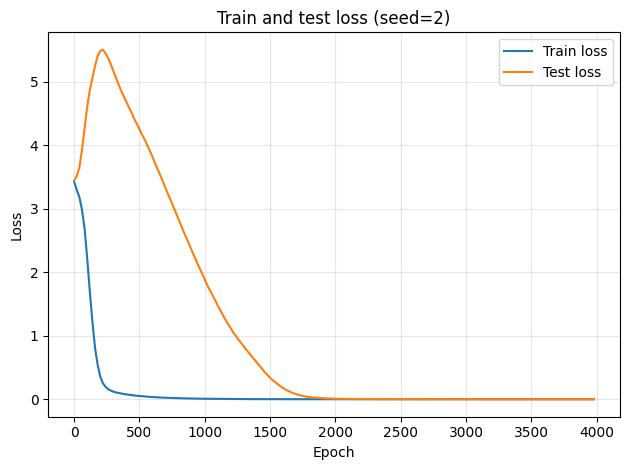

In [19]:
x_axis = np.arange(start=0, stop=params.epochs, step=params.log_every)

plt.plot(x_axis, tr_loss, label="Train loss")
plt.plot(x_axis, te_loss, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and test loss (seed=2)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

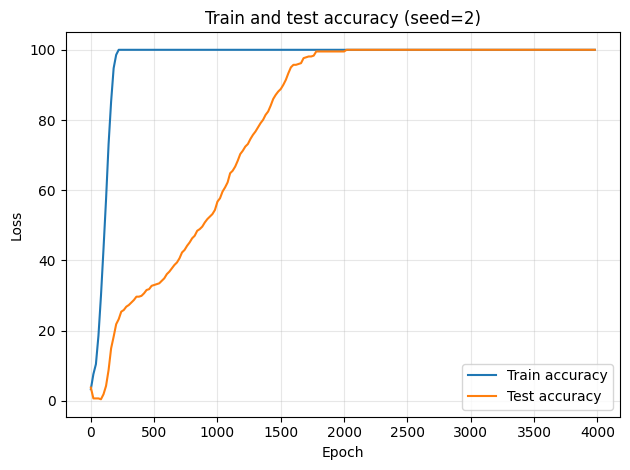

In [20]:
x_axis = np.arange(start=0, stop=params.epochs, step=params.log_every)

plt.plot(x_axis, tr_acc, label="Train accuracy")
plt.plot(x_axis, te_acc, label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and test accuracy (seed=2)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

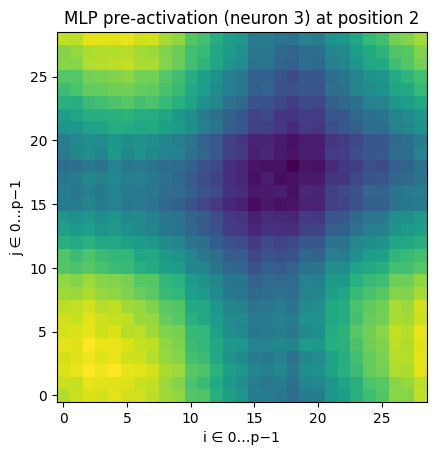

In [27]:
# === Visualize MLP pre-activation for a single neuron over all (i, j) ===
import matplotlib.pyplot as plt

device = next(model.parameters()).device
p = params.p
pos = 2        # which position's MLP pre-activation to visualize (0, 1, or 2)
k = 3         # neuron index in the MLP hidden layer (0 .. d_mlp-1)

# Build the full grid (i, j, <third token = p>) using your data helper
X_dummy, _ = gen_total_data(p)                    # X shape: [p^2, 3] with last token = p
seq = t.tensor(X_dummy, dtype=t.long, device=device)

# Capture the MLP pre-activation: pre = x_after_attn @ W_in
caps = []
def mlp_preact_hook(module, inp, out):
    x_after_attn = inp[0]                   # shape [B, S, d_model]
    pre = x_after_attn @ module.W_in        # shape [B, S, d_mlp]
    caps.append(pre.detach())

h = model.transformer_block.mlp.register_forward_hook(mlp_preact_hook)
with t.no_grad():
    _ = model(seq)                          # forward produces logits at pos=2; hook grabs pre-acts
h.remove()

pre = t.cat(caps, dim=0)                    # [p^2, 3, d_mlp]
img = pre[:, pos, k].reshape(p, p).detach().cpu().numpy()

plt.figure()
plt.imshow(img, origin='lower',
           extent=[-0.5, p-0.5, -0.5, p-0.5], interpolation='none')
plt.gca().set_aspect('equal', 'box')
plt.xlabel('i ∈ 0…p−1'); plt.ylabel('j ∈ 0…p−1')
plt.title(f"MLP pre-activation (neuron {k}) at position {pos}")
plt.show()

Let's check that the embedding matrix localizes to a few Fourier frequencies. In particular, following Nanda et al. we compute the Fourier transform along the input dimension of W_E (of dim p) and compute the l^2 norm along the othe direction.

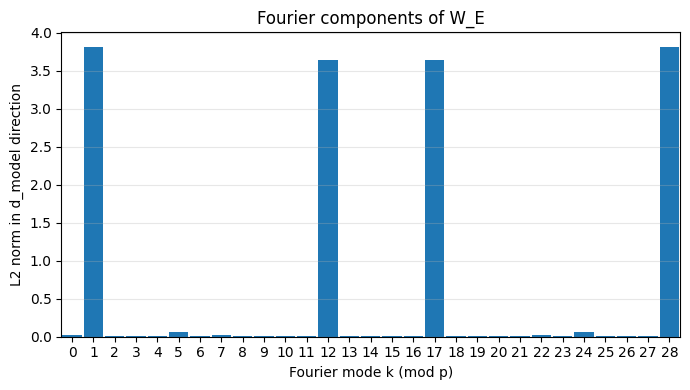

In [28]:
W_E = model.embed.W_E.detach().to("cpu")[:params.p, :]    # shape (p, d_model)
spectrum = t.fft.fft(W_E, dim=0)                          # FT along imput direction. Shape (p, d_model)

l2_norm = (spectrum.abs() ** 2).mean(dim=1).numpy()
freqs = np.arange(params.p)

fig, ax = plt.subplots(figsize=(7, 4))
ax.bar(freqs, l2_norm, width=0.9, align="center")
ax.set_xlabel("Fourier mode k (mod p)")
ax.set_ylabel("L2 norm in d_model direction")
ax.set_title("Fourier components of W_E")
ax.set_xlim(-0.5, len(freqs) - 0.5)

# Keep ticks readable for large p
if len(freqs) <= 40:
    ax.set_xticks(freqs)
else:
    step = max(1, len(freqs)//20)
    ax.set_xticks(np.arange(0, len(freqs), step))

ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Interpret eNTK eigenvectors

## 2.1. Indicators*

In [29]:
def fourier_cols(vals: np.ndarray, p: int) -> np.ndarray:
  """
  Build [cos(2π k val/p), sin(2π k val/p)] stacked column-wise.
  Return float32 array (N, floor(p//2), 2).
  """
  v = vals % p
  cols = []
  for k in range(1, p//2+1):
    ang = 2 * np.pi * k * v / p
    cols.append(np.stack((np.cos(ang), np.sin(ang)), axis=-1))  # (N, 2)
  F = np.stack(cols, axis=1).astype(np.float32)  # (N, floor(p//2), 2)
  return F


def build_fourier_features(labels: np.ndarray, p: int, k: np.ndarray = None):
  """
  labels: (N,2) int array
  p     : modulus (odd)

  Returns: dict of real Fourier features:
    'n', 'm', 'sum', 'diff': (N, floor(p//2), 2)

  If option k is selected, return Fourier features at the frequencies specified by k only
  (N, k, 2).
  """
  feats: Dict[str, np.ndarray] = {}

  left = labels[:, 0]
  right = labels[:, 1]

  # --- First-layer preactivation features ---------------------------------
  feats['n'] = fourier_cols(left, p)              #(N, floor(p//2), 2)
  feats['m'] = fourier_cols(right,p)

  # --- First-layer activation features ------------------------------------
  sum_mod  = (left + right) % p
  diff_mod = (left - right) % p
  feats['sum'] = fourier_cols(sum_mod, p)
  feats['diff'] = fourier_cols(diff_mod, p)
  #feats['2n'] = fourier_cols(2 * left, p)
  #feats['2m'] = fourier_cols(2 * right, p)

  # --- New hypotheses ------------------------------------
  feats['axis_sum'] = feats['n'] + feats['m']
  n2 = fourier_cols(2 * left,  p)
  m2 = fourier_cols(2 * right, p)
  feats['axis2_sum'] = n2 + m2


  # --- Second-layer preactivation features --------------------------------
  '''R = np.empty((labels.shape[0], p, p//2, 2))
  for q in range(p):
    R[:, q, :, :] = fourier_cols((sum_mod - q), p)
  feats['readout'] = R'''

  if k != None:
    feats['n'] = feats['n'][:, k, :]
    feats['m'] = feats['m'][:, k, :]
    feats['sum'] = feats['sum'][:, k, :]
    feats['diff'] = feats['diff'][:, k, :]
    feats['axis_sum'] = feats['axis_sum'][:, k, :]
    feats['axis2_sum'] = feats['axis2_sum'][:, k, :]

  return feats

In [30]:
feats = build_fourier_features(X[:,:2].cpu().numpy(), params.p, k= [0,2,9])

## 2.2 Kernel and disentanglement algorithm.

### 2.2.1. Kernels*

In [31]:
entk = empirical_ntk_by_layer_cpu(model.to(device), X.to(device), X.to(device))

In [32]:
print(*entk)

embed.W_E pos_embed.W_pos transformer_block.attn.W_Q transformer_block.attn.W_K transformer_block.attn.W_V transformer_block.attn.W_O transformer_block.mlp.W_in transformer_block.mlp.W_out unembed.W_U


In [33]:
vals = list(entk.values())
entk_full = t.zeros_like(vals[0])
for K in vals:
  entk_full += K

In [34]:
eigvals, eigvecs = eig_decompose((entk['transformer_block.mlp.W_out'][:,:,:30,:30]).mean(dim=(2,3)), topk=40)

In [27]:
eigvals, eigvecs = eig_decompose(((entk['unembed.W_U'])[:,:,:30,:30]).mean(dim=(2,3)), topk=40)

In [30]:
eigvals, eigvecs = eig_decompose((entk['transformer_block.mlp.W_out'][:,:,:30,:30] + entk['unembed.W_U'][:,:,:30,:30]).mean(dim=(2,3)), topk=40)

In [ ]:
eigvals, eigvecs = eig_decompose((entk_full[:,:,:30,:30]).mean(dim=(2,3)), topk=40)

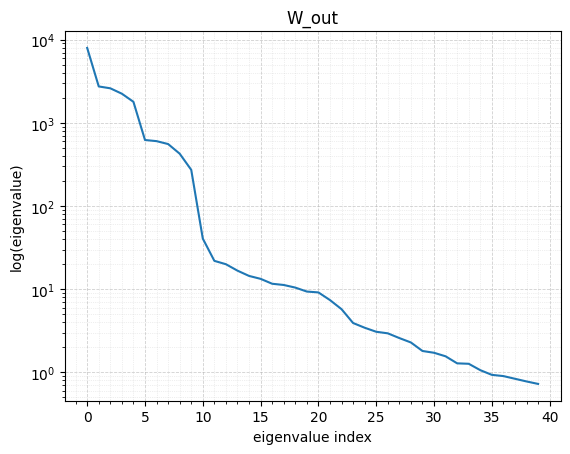

In [35]:
plt.plot(eigvals[:40].detach().cpu().numpy())
plt.yscale('log')
plt.title("W_out")
plt.xlabel("eigenvalue index")
plt.ylabel("log(eigenvalue)")


plt.minorticks_on()
plt.grid(True, which='major', axis='both', linestyle='--', linewidth=0.6, alpha=0.6)
plt.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5, alpha=0.4)

### Per-head stufff below this line. *** RESUME FROM HERE ****

This code needs work.

In [ ]:
# PER-HEAD VERSION OF LAYERWISE NTK - BUGGY/NEED TO FIX -

from collections import OrderedDict
from typing import Tuple, List, Optional, Set
from functorch import make_functional, jacrev, vmap
import torch as t
import torch.nn as nn

def empirical_ntk_by_layer(
    model: nn.Module,
    x_1: t.Tensor,
    x_2: t.Tensor,
    *,
    n1_chunk: int = 64,
    n2_chunk: int = 64,
    c1_chunk: int = 8,
    c2_chunk: int = 8,
    include_params: Optional[Set[str]] = None,  # restrict which param *names* to include
    head_index: Optional[int] = None,           # if not None, only that attention head
) -> "OrderedDict[str, t.Tensor]":
    """
    Memory-lean NTK by layer/parameter-group, with optional:
      - include_params: only compute for these parameter names
      - head_index: for attention Q/K/V, compute only a single head slice

    Returns:
        OrderedDict[group_name, Tensor] of shape (N1, N2, C, C) on CPU.

        If head_index is not None and param is attention Q/K/V:
            group_name = "<param_name>.head{head_index}"
        Otherwise:
            group_name = "<param_name>"
    """
    model = model.eval()
    fmodel, params = make_functional(model)

    # Per-head attention params in THIS model:
    ATTN_HEAD_PARAM_NAMES = {
        "transformer_block.attn.W_Q",
        "transformer_block.attn.W_K",
        "transformer_block.attn.W_V",
        "transformer_block.attn.W_O"
    }
    # W_Q/K/V shapes: (n_heads, d_head, d_model)
    HEAD_DIM = 0

    param_items: List[Tuple[str, t.Tensor]] = list(model.named_parameters())

    with t.no_grad():
        out_shape = fmodel(params, x_1[:1]).shape
        C = out_shape[-1]
    N1, N2 = x_1.shape[0], x_2.shape[0]
    device = x_1.device

    out_by_group: "OrderedDict[str, t.Tensor]" = OrderedDict()

    def ensure_group_allocated(group: str):
        if group not in out_by_group:
            out_by_group[group] = t.zeros(
                (N1, N2, C, C),
                dtype=t.float32,
                device="cpu",
            )

    def make_f_for_param(
        param_index: int,
        class_slice: slice,
        head_idx: Optional[int] = None,
    ):
        """
        If head_idx is None: theta is the full param tensor.
        If head_idx is int:   theta is a single head slice along HEAD_DIM.
        """
        base_param = params[param_index].detach()

        if head_idx is None:
            def f_only_theta(theta: t.Tensor, x_single: t.Tensor) -> t.Tensor:
                plist = list(params)
                plist[param_index] = theta
                for k, p in enumerate(plist):
                    if k != param_index:
                        plist[k] = p.detach()
                y = fmodel(tuple(plist), x_single.unsqueeze(0))  # [1, C]
                y = y.squeeze(0)                                # [C]
                return y[class_slice]                           # [c_block]
        else:
            def f_only_theta(theta: t.Tensor, x_single: t.Tensor) -> t.Tensor:
                plist = list(params)

                full = base_param.clone()
                idx = [slice(None)] * full.ndim
                idx[HEAD_DIM] = head_idx
                full[tuple(idx)] = theta

                plist[param_index] = full
                for k, p in enumerate(plist):
                    if k != param_index:
                        plist[k] = p.detach()

                y = fmodel(tuple(plist), x_single.unsqueeze(0))  # [1, C]
                y = y.squeeze(0)                                # [C]
                return y[class_slice]                           # [c_block]
        return f_only_theta

    def batched_param_jac(
        param_index: int,
        class_slice: slice,
        xb: t.Tensor,
        head_idx: Optional[int] = None,
    ) -> t.Tensor:
        """
        Jacobian w.r.t. either the full param or a single head slice.
        Returns: [batch, c_block, *theta_shape]
        """
        f_theta = make_f_for_param(param_index, class_slice, head_idx=head_idx)
        jac_fn = vmap(jacrev(f_theta), (None, 0))

        if head_idx is None:
            theta0 = params[param_index]
        else:
            base_param = params[param_index]
            idx = [slice(None)] * base_param.ndim
            idx[HEAD_DIM] = head_idx
            theta0 = base_param[tuple(idx)]

        return jac_fn(theta0, xb)

    # Main loops
    for p_idx, (p_name, p_tensor) in enumerate(param_items):
        # If include_params is given, skip everything else.
        if include_params is not None and p_name not in include_params:
            continue

        # Decide grouping behavior
        is_attn = p_name in ATTN_HEAD_PARAM_NAMES
        # If head_index is provided AND this is an attention param, we do per-head.
        if is_attn and head_index is not None:
            # Sanity: make sure head_index is in range
            assert 0 <= head_index < p_tensor.shape[HEAD_DIM], \
                f"head_index {head_index} out of range for {p_name} with shape {p_tensor.shape}"
            head_indices = [head_index]
            head_labels = [f"{p_name}.head{head_index}"]
        else:
            # Either non-attention, or head_index=None: treat whole tensor as one group
            head_indices = [None]
            head_labels = [p_name]

        for g in head_labels:
            ensure_group_allocated(g)

        for h_idx, group in zip(head_indices, head_labels):
            for i1 in range(0, N1, n1_chunk):
                xb1 = x_1[i1 : i1 + n1_chunk].to(device, non_blocking=True)

                for j2 in range(0, N2, n2_chunk):
                    xb2 = x_2[j2 : j2 + n2_chunk].to(device, non_blocking=True)

                    c_start = 0
                    while c_start < C:
                        c_end = min(c_start + c1_chunk, C)
                        c_slice = slice(c_start, c_end)

                        J1 = batched_param_jac(
                            p_idx, c_slice, xb1, head_idx=h_idx
                        )
                        J1f = J1.flatten(start_dim=2)  # [n1, c1, P_eff]
                        del J1
                        if t.cuda.is_available():
                            t.cuda.empty_cache()

                        d_start = 0
                        while d_start < C:
                            d_end = min(d_start + c2_chunk, C)
                            d_slice = slice(d_start, d_end)

                            J2 = batched_param_jac(
                                p_idx, d_slice, xb2, head_idx=h_idx
                            )
                            J2f = J2.flatten(start_dim=2)  # [n2, d1, P_eff]
                            del J2
                            if t.cuda.is_available():
                                t.cuda.empty_cache()

                            contrib = t.einsum("ncp,mdp->nmcd", J1f, J2f)
                            out_by_group[group][
                                i1 : i1 + contrib.shape[0],
                                j2 : j2 + contrib.shape[1],
                                c_start : c_end,
                                d_start : d_end,
                            ] += contrib.detach().to("cpu")

                            del J2f, contrib
                            if t.cuda.is_available():
                                t.cuda.empty_cache()
                            d_start = d_end

                        del J1f
                        if t.cuda.is_available():
                            t.cuda.empty_cache()
                        c_start = c_end

                    del xb2
                    if t.cuda.is_available():
                        t.cuda.empty_cache()

                del xb1
                if t.cuda.is_available():
                    t.cuda.empty_cache()

    return out_by_group

In [ ]:
attn_params = {
    "transformer_block.attn.W_Q",
    "transformer_block.attn.W_K",
    "transformer_block.attn.W_V",
    "transformer_block.attn.W_O"
}

# Example: head 0
entk_head0 = empirical_ntk_by_layer(
    model,
    X,
    X,
    include_params=attn_params,
    head_index=0,
)

In [ ]:
# Example: head 1
entk_head1 = empirical_ntk_by_layer(
    model,
    X,
    X,
    include_params=attn_params,
    head_index=1,
)

In [ ]:
# Example: head 2
entk_head2 = empirical_ntk_by_layer(
    model,
    X,
    X,
    include_params=attn_params,
    head_index=2,
)

In [ ]:
# Example: head 3
entk_head3 = empirical_ntk_by_layer(
    model,
    X,
    X,
    include_params=attn_params,
    head_index=3,
)

### 2.2.2. Disentanglement

#### Check subspace overlaps/Frobenius norm.

In [ ]:
#feats = build_fourier_features(X[:,:2].cpu().numpy(), params.p, k= [0,2,9])
feats = build_fourier_features(X[:,:2].cpu().numpy(), params.p, k=[0,9,11])

In [ ]:
c1 = eigvecs[:,1:7].to(device)
Q = c1.cpu().numpy()

In [ ]:
c1 = eigvecs[:,7:13].to(device)
Q = c1.cpu().numpy()

In [ ]:
def _mat(feats, key):
    # feats[key]: (N, K, 2) -> (N, 2K)
    F = feats[key].reshape(feats[key].shape[0], -1).astype(np.float64)
    F -= F.mean(0, keepdims=True)                    # drop constant mode
    return F

def _orth(X):
    # column-orthonormalize (works even if X not full rank)
    # also normalizes tiny-norm columns away
    q, _ = np.linalg.qr(X, mode="reduced")
    return q

def subspace_overlap(Q_cliff, feats, key):
    """
    Q_cliff: (N, d) eigenvectors for a cliff (columns, not rows)
    feats:   dict from your feature-bank builder
    key:     'axis_sum', 'axis2_sum', 'sum', 'diff', 'n', 'm', ...

    Returns:
      sing_vals: singular values of Q^T F (length <= min(d, 2K))
      overlap:   Frobenius^2 = sum(sing_vals**2) \in [0, d]
    """
    Q = _orth(Q_cliff.astype(np.float64))
    F = _orth(_mat(feats, key))
    s = np.linalg.svd(Q.T @ F, compute_uv=False)
    return s, float((s**2).sum())

<>:21: SyntaxWarning: invalid escape sequence '\i'
<>:21: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipython-input-2897602293.py:21: SyntaxWarning: invalid escape sequence '\i'
  overlap:   Frobenius^2 = sum(sing_vals**2) \in [0, d]


In [ ]:
s, ov = subspace_overlap(Q, feats, key='sum')
print("singular values:", s, "   overlap:", ov)

singular values: [0.94265868 0.92446224 0.89234326 0.36957542 0.05963626 0.03994985]    overlap: 2.681250789447679


Code to check overlaps beyond the key frequences (I ended up not using this)

In [ ]:
feats = build_fourier_features(X[:,:2].cpu().numpy(), params.p)

In [ ]:
c1 = eigvecs[:,7:15].to(device)
Q = c1.cpu().numpy()

In [ ]:
def subspace_overlap_2(Q_cliff, feats, key='axis_sum'):
    """
    Returns:
      scores: length-K_all array; score[k] in [0,2] is the overlap of the cliff
              with the axis-sum cos/sin pair at frequency k
      order:  indices of frequencies sorted by descending score
    """
    Q = _orth(Q_cliff.astype(np.float64))           # (N, d) -> orthonormal
    F = _mat(feats, key)                            # (N, 2*K_all), unnormalized -> centered
    K_all = F.shape[1] // 2
    scores = np.empty(K_all, dtype=np.float64)
    for k in range(K_all):
        Fk = _orth(F[:, 2*k:2*k+2])                 # (N,2), orthonormalize the cos/sin pair
        s = np.linalg.svd(Q.T @ Fk, compute_uv=False)
        scores[k] = (s**2).sum()                    # ∈ [0,2]; ~2 if both cos/sin lie in the cliff
    order = np.argsort(-scores)
    return scores, order

In [ ]:
scores, order = subspace_overlap_2(Q, feats, key='sum')
top_freqs = order[:4]            # the four frequencies forming the 8-dim cliff
top_scores = scores[order[:4]]   # should be close to 2 each

print(top_freqs, top_scores)

[11  9  0  1] [1.91727011 1.73580513 1.69619816 0.00538127]


#### Rotation (from previous ppaer)

In [ ]:
@t.no_grad()
def phase_insensitive_corr(cols: t. Tensor, binary_indicators: np.ndarray) -> np.ndarray:
  """
  Inputs:
    cols: shape (N,k) t.Tensor with N = number of dataset points; k = size of eigenvalue cliff.
    binary_indicators: shape (N,K,2) pair of indicators from binary_indicator function above, with K = floor (p//2).

  Outputs:
    shape (K,k) thing that we plot in the heatmap.
  """
  A = cols / (cols.norm(dim=0, keepdim=True) + 1e-12)
  F = t.from_numpy(binary_indicators).to(A.device, A.dtype)
  F = F / (t.linalg.norm(F, dim=0, keepdim=True) + 1e-12)
  H = (F.permute(2,1,0) @ A).norm(dim=0)
  return H.cpu().numpy()

In [ ]:
def sum_laplacian_pxp(p: int, device=None, dtype=t.float32):
    p = int(p)
    N = p * p
    idx = t.arange(N, device=device).reshape(p, p)  # (n,m) -> linear i

    def perm_from_roll(dx, dy):
        # permutation matrix for (n,m) -> (n+dx, m+dy) mod p
        perm = idx.roll(shifts=(dx, dy), dims=(0, 1)).reshape(-1)  # target rows
        S = t.zeros((N, N), device=device, dtype=dtype)
        S[perm, t.arange(N, device=device)] = 1.0
        return S

    I_N = t.eye(N, device=device, dtype=dtype)

    # Sum direction: (+1,+1), (-1,-1)
    S_sp = perm_from_roll(+1, +1)
    S_sm = perm_from_roll(-1, -1)

    Ls = 2 * I_N - S_sp - S_sm

    ## Symmetrize & make contiguous
    Ls = (0.5 * (Ls + Ls.T))
    #Ld = (0.5 * (Ld + Ld.T))
    return Ls

In [ ]:
def axis_diagonalization(
    c1: t.Tensor, L1: t.Tensor
) -> t.Tensor:
    """
    Diagonalize L1 inside span(c1) -> sort by n-frequency.
    Then within the 0-eigenvalue eigenspace of L1, diagonalize L2 -> sort by m-frequency.

    Return U(N,k): basis of c1 (...)
    """
    N, k = c1.shape
    Q = t.linalg.qr(c1, mode="reduced")[0]

    # Diagonalize L1 inside span(c1) -> sort by n-frequency.
    An = Q.T @ L1 @ Q
    vals, vecs_n = t.linalg.eigh(An)
    Q1 = Q @ vecs_n

    return Q1

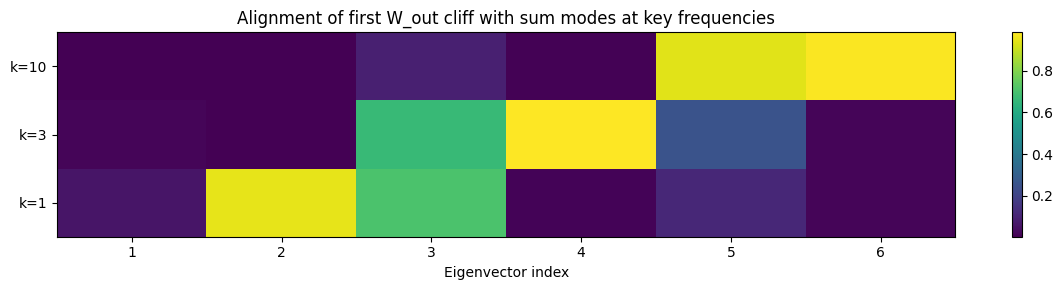

In [ ]:
Ls = sum_laplacian_pxp(params.p)
U = axis_diagonalization(c1, Ls.to(device))

# --- 4) Plot stacked n/m heatmaps (phase-insensitive, for evaluation) -----

Hn = phase_insensitive_corr(U, feats['sum'])                 # (K,56)   # n->a, m->b   So bottom 28 modes correspond to 'b' and next to 'a'

plt.figure(figsize=(12,3))
plt.imshow(Hn, cmap='viridis', origin='lower', aspect='auto')
plt.colorbar()
Khalf = Hn.shape[0]
#yt = [f"a k={i+1}" for i in range(Khalf)] + [f"b k={i+1}" for i in range(Khalf)]
#plt.yticks(range(stacked.shape[0]), yt)
plt.xticks(range(Hn.shape[1]), [1,2,3,4,5,6])
plt.yticks(range(3), ["k=1", "k=3", "k=10"])
plt.xlabel("Eigenvector index")
plt.title("Alignment of first W_out cliff with sum modes at key frequencies")
plt.tight_layout(); plt.show()

# Optional: quick diagnostic—axis separation
#plt.figure(figsize=(5,5))
#plt.scatter(en, em, s=20, alpha=0.8)
#plt.xlabel("Rayleigh(L_n)"); plt.ylabel("Rayleigh(L_m)")
#plt.title("Per-atom axis energies (lower=axis-invariant)")
#plt.tight_layout(); plt.show()